# Final Project
Jack Dean  
Math 469 - Financial Stochastic Analysis  
Lehigh University

In [1]:
'''
Packages used
'''
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Generate US Treasury Term Structure

In [2]:
'''
Pull rates data
---
Rates data saved in an excel spreadsheet
Aggregated with market data from wsj
https://www.wsj.com/market-data/bonds/treasuries
'''
t_bonds_df = pd.read_excel('Table.xlsx', sheet_name='bonds')
t_bonds_df['px_last'] = [i if i>=25 else 100 - i for i in t_bonds_df['ask'].to_list()]
t_bonds_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in t_bonds_df['maturity']]
t_bonds_df['bond'] = ['T '+ str(t_bonds_df.iloc[i,1]) + ' '+ t_bonds_df.iloc[i,0].strftime('%m/%d/%y') for i in t_bonds_df.index]
t_bonds_df = t_bonds_df.set_index('bond')
t_bonds_df.head()

,maturity,coupon,bid,ask,ask_yield,px_last,ttm
bond,,,,,,,
T 0.0 06/16/22,2022-06-16,0.0,0.408,0.398,0.403,99.602,0.001579
T 0.0 06/21/22,2022-06-21,0.0,0.720,0.710,0.720,99.290,0.015277
T 0.0 06/23/22,2022-06-23,0.0,0.720,0.710,0.720,99.290,0.020757
T 0.0 06/28/22,2022-06-28,0.0,0.823,0.813,0.824,99.187,0.034455
T 0.0 06/30/22,2022-06-30,0.0,0.988,0.978,0.992,99.022,0.039935


In [3]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in t_bonds_df[t_bonds_df['ttm'] <= 0.5].index:
    bond = t_bonds_df.loc[bond_tenor]
    cpn = bond['coupon']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in t_bonds_df[t_bonds_df['ttm']>=0.5].index:
    bond = t_bonds_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['coupon']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

Text(0, 0.5, 'Yield (per annum, continuous)')

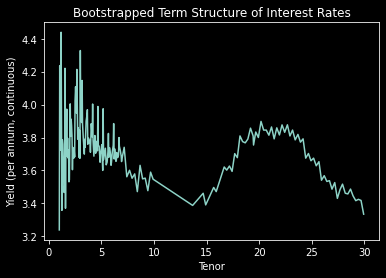

In [4]:
'''
plot bootstrapped yield curve
'''
plt.plot(rates[1:] * 100)
plt.title('Bootstrapped Term Structure of Interest Rates')
plt.xlabel('Tenor')
plt.ylabel('Yield (per annum, continuous)')

## Construct Current Fed Dot Plot

In [5]:
'''
Pull Current boxplot data
---
Data saved in excel file but accessed here
https://www.federalreserve.gov/monetarypolicy/fomcprojtable20220316.htm
'''
dot_df = pd.read_excel('Table.xlsx',sheet_name='dots')
dot_df.columns = ['pct','2022','2023','2024','2025']
dot_df = dot_df.set_index('pct')#.fillna(0)
dot_df

,2022,2023,2024,2025
pct,,,,
3.750,NaN,NaN,NaN,NaN
3.625,NaN,2.0,2.0,NaN
3.500,NaN,NaN,NaN,NaN
3.375,NaN,1.0,2.0,NaN
3.250,NaN,NaN,NaN,NaN
3.125,1.0,2.0,1.0,NaN
3.000,NaN,NaN,NaN,2.0
2.875,NaN,3.0,3.0,NaN
2.750,NaN,NaN,NaN,NaN


In [6]:
'''
Calculate Average Rate Target by year
'''
fomc = [(dot_df.index*dot_df[year]).sum() / dot_df[year].sum() for year in dot_df.columns]
hike_years = [datetime.date(int(year),month=12,day=31) for year in dot_df.columns]
fomc_df = pd.DataFrame(fomc, hike_years,columns=['Average Target'])
fomc_df['Mode'] = dot_df.idxmax().to_list()
fomc_df

,Average Target,Mode
2022-12-31,2.046875,1.875
2023-12-31,2.812500,2.375
2024-12-31,2.789062,2.875
2025-12-31,2.425000,2.250


## Ho-Lee Model Analysis

**Definition**: Ho-Lee Model, an affine model of the form
$$dr_t = \theta(t)dt + \sigma dW_t$$

We have the price of a bond
$$B(t,T) = \mathrm{exp}\{-Y(t,T)\} = \mathrm{exp}\{\int_t^Tr_sds\} = \mathrm{exp}\{-r_0(T-t) - \int_t^T\Theta(s)ds - \sigma(T-t)W_t + \sigma^2\frac{(T-t)^3}{6}\}$$
$$\implies Y(0,T) = r_0T + \int_0^T\Theta(s)ds - \sigma^2\frac{T^3}{6}$$
Which means we can use the yield curve to solve for the function $\Theta(t)$.  Using this function, we can forecast the short rate

Regarding data, we assume the short rate $r_0$ to be the current Fed-Funds Rate (target of 100 basis points) and the volatility $\sigma$ to be the current ICE BofA MOVE Index, a market index that tracks implied rates volatility (the rates equivalent of the VIX index).

In [7]:
'''
Simulate 10K brownian motions of length 30 years
'''
M = 10000                                                       # 10K brownian motions -- TRIAL COUNT FOR ENTIRE FILE
n = 30 * 100                                                    # 30 years by 100 time steps per year
w_t = []
for i in range(M):
    w_t.append(np.cumsum(np.random.randn(n)*np.sqrt(0.01)))
t_i = np.array([i/100 for i in range(n)])

Text(0, 0.5, 'Value')

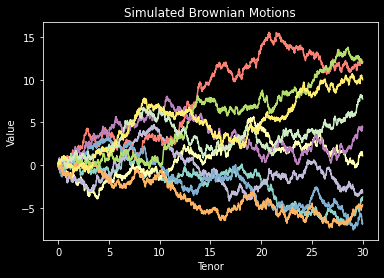

In [8]:
'''
Plot Brownian motions to confirm
'''
plt.plot(t_i,w_t[0])
plt.plot(t_i,w_t[1])
plt.plot(t_i,w_t[2])
plt.plot(t_i,w_t[3])
plt.plot(t_i,w_t[4])
plt.plot(t_i,w_t[5])
plt.plot(t_i,w_t[6])
plt.plot(t_i,w_t[7])
plt.plot(t_i,w_t[8])
plt.plot(t_i,w_t[9])
plt.title('Simulated Brownian Motions')
plt.xlabel('Tenor')
plt.ylabel('Value')

In [9]:
'''
Parameter Estimations - MARKET DATA
---
r_0 - instantaneous short rate (fed funds tager)
move - ICE BofA Rates Vol Index (ticker: MOVE)
'''
r_0 = 0.0083              # fed funds target
move = 144.09 / 100     # MOVE index

In [10]:
'''
Numerically approximate Theta
'''
Theta = []
Theta.append([(rates.loc[t] - r_0*t + (move**2 * t**3)/6)[0] for t in rates.index])
theta_est = pd.DataFrame(data=Theta,columns=rates.index).transpose().diff().dropna()

Text(0.5, 1.0, 'Estimated Theta Function')

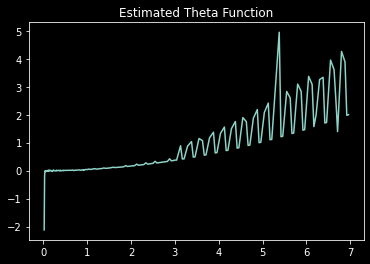

In [11]:
plt.plot(theta_est[:7])
plt.title('Estimated Theta Function')

In [12]:
'''
Calculates short rate forecasts
---
puts brownian motions into dataframe for comprehension
merges each brownian motion with estimated theta param, sums it, and add short rate
takes average of the 10k trials (monte carlo)
Creates a rate hike forecast dataframe for next 1200 calendar days
'''
wt_df = pd.DataFrame(w_t, columns=t_i).transpose()

short_rate_estimate = [pd.merge(
    left = theta_est,
    right = wt_df[i],
    how = 'left',
    left_index = True,
    right_index = True
    ).transpose().sum()
for i in range(M)]

r0_estimate = pd.DataFrame(short_rate_estimate).mean() + r_0

r0_estimate.index = [datetime.timedelta(days=r0_estimate.index[i]*365) + datetime.datetime.now() for i in range(len(r0_estimate))]
rate_hike_forecast = r0_estimate.loc[datetime.datetime.now()+datetime.timedelta(days=7):datetime.datetime.now()+datetime.timedelta(days=800)]*10000

Text(0, 0.5, 'Rate in Basis Points')

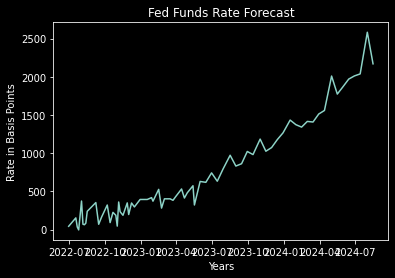

In [13]:
'''
plots rate hike forecast
'''
plt.plot(rate_hike_forecast[rate_hike_forecast>=-100] + 83)
plt.title('Fed Funds Rate Forecast')
plt.xlabel('Years')
plt.ylabel('Rate in Basis Points')

## Putting it All Together

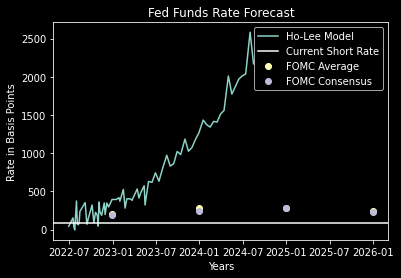

In [14]:
'''
plots rate hike forecast and FOMC Targets for comparison
'''
plt.plot(rate_hike_forecast[rate_hike_forecast>=-100] + 83)
plt.axhline(83)
plt.plot(fomc_df*100,'o')
plt.title('Fed Funds Rate Forecast')
plt.xlabel('Years')
plt.ylabel('Rate in Basis Points')
plt.legend(['Ho-Lee Model','Current Short Rate','FOMC Average','FOMC Consensus'])